<a href="https://colab.research.google.com/github/kimberlyhau/StockMarketPredictor/blob/main/MiniProject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Library Imports and Movie Data Import
import pandas as pd
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta



ratings = pd.read_csv("http://www.cs.toronto.edu/~guerzhoy/324/movielens/ratings.csv")
print(torch.cuda.is_available())

True


<h1> ECE324 Mini Project 2: Recommending Movies with Graphs </h1>

<h3>Clean, Preapre and Sort Master Dataframe</h3>

In [2]:
###Get Standard Data needed for embeddings
###Organize Data and Sort by Timestamps
##Clean up Ratings Matrix
#From Data Source: "Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.""
startDate = datetime(1970, 1,1,0,0,0) #start date
ratings['timestamp'] = pd.to_datetime(startDate + pd.to_timedelta(ratings['timestamp'], unit='s')) #update dates
ratings.sort_values(by=['userId','timestamp']) #sort values

#add targets based on whether or not the user ranked the movie 5 stars
ratings['targets'] = np.where(ratings['rating']== 5, 1, 0)

#number users and all ids
users = sorted(list(ratings['userId'].unique()))
n_users = len(users)

#number movies and all movies
movies = sorted(list(ratings['movieId'].unique()))
n_movies = len(movies)

#movies and users are not ided consectuively. Some are missing. Replace with consecutive numbers to have enough space when making matrix. 
mappedMovies = [i for i in range(n_movies)]
mappedUsers = [i for i in range(n_users)]
movieDict = {}
for i in range(0,len(movies)):
    movieDict[movies[i]] = mappedMovies[i]

userDict = {}
for i in range(0,len(users)):
    userDict[users[i]] = mappedUsers[i]

#replace the movie and user id with the mapped index (to get rid of 0)
ratings['movieId'] = ratings['movieId'].replace(sorted(movies),mappedMovies)
ratings['userId'] = ratings['userId'].replace(sorted(users),mappedUsers)


<h2> Part 1: Learned Embeddings </h2>

<h3> Prepare Test and Train Data </h3>

In [46]:
###Split Data in Train/Test Set. Use 80/20 split.
#store train and test df
trainDf = []
testDf = []

#loop for all users
for i in range(n_users):
    tempUser = ratings[ratings['userId'] == i].copy().reset_index(drop = True) #df corresponding to this user
   
    n_temp_user = len(tempUser) #number of rows in df corresponding to this user
    n_train = int(0.8*n_temp_user) #make 80% of these rows for train set
    
    #split df corresponding to this user into train and test set
    trainDf.append(tempUser.iloc[0:n_train])
    testDf.append(tempUser.iloc[n_train:])

#concat df's
trainDf = pd.concat(trainDf).reset_index(drop = True)
testDf = pd.concat(testDf).reset_index(drop = True)

<h3> Prepare Adjacency Matrix </h3>

In [47]:
###Make Adjacency Matrix: Make 4 seprate matrix, then combine. Need one for test and one for train.
#train set
A_train = np.zeros((n_users,n_movies))

#test set
A_test = np.zeros((n_users,n_movies))

##Fill in the userxmovie matrix. Make graph to find which movies each user rated 5 stars.
for x in range(0,n_users):
    ##train set
    #query dataframe for subset belonging to user x
    usersRow_train = trainDf[trainDf['userId'] == x]
    #Get index corresponding to movie, get targets ( whether or not user gave it 5 stars)
    movieIdx_train = list(usersRow_train['movieId'])
    didGiveFive_train = list(usersRow_train['targets'])
    #update dataframe
    A_train[x][movieIdx_train] = didGiveFive_train

    ##test set 
    #query dataframe for subset belonging to user x
    usersRow_test = testDf[testDf['userId'] == x]
    #Get index corresponding to movie, get targets ( whether or not user gave it 5 stars)
    movieIdx_test = list(usersRow_test['movieId'])
    didGiveFive_test = list(usersRow_test['targets'])
    #update dataframe
    A_test[x][movieIdx_test] = didGiveFive_test

###Convert to Tensor 
A_train_Tensor = torch.LongTensor(A_train).to('cuda') #train tensor
A_test_Tensor = torch.LongTensor(A_test).to('cuda') #test tensor

<h3> Embeddings Model </h3>

In [48]:
#Embeddings
class Embedding(torch.nn.Module):
    def __init__(self, n_user, n_movies, d):        
        super(Embedding, self).__init__()
        self.user_embedding = nn.Embedding(n_user,d) #user embeddings
        self.movie_embedding = nn.Embedding(n_movies,d) #movie embeddings
        self.user = n_user #number of users
        self.movies = n_movies #number of movies
        nn.init.uniform_(self.user_embedding.weight, -0.01, 0.01) #init user embeddings
        nn.init.uniform_(self.movie_embedding.weight, -0.01, 0.01) #init movie embeddings
         

<h3> Recall@150 Function </h3>

In [6]:
#recall@150
def recall150(tensor,df, model,users,movies):

  #Get embeddings
  user_embd_train = model.user_embedding(torch.LongTensor(users).to('cuda')) #user embedding
  movie_embd_train = model.movie_embedding(torch.LongTensor(movies).to('cuda')).T #movie embedding

  #rankings matrix 
  rankings = torch.matmul(user_embd_train,movie_embd_train)

  #top 150 rankings for each user
  top150 =  torch.topk(rankings, 150) 

  #store for results
  recall150 = []  

  #loop for each user  
  for u in range(n_users):

      movies_u_5 = set([torch.where(tensor[u] == 1)][0][0]) #movies the user rated 5 stars

      #if the user rated movies 5 stars
      if len(movies_u_5) != 0: 
        modelResults = set(np.array(top150.indices[u].cpu())) #top 150 recommendations 
        trueResults = set(df[df['userId'] == u ]['movieId'].to_list()) #movies user u has seen
        seen = len(modelResults&trueResults) #intersection of seen and recommendation
        recall150.append(seen/len(movies_u_5))#add recall@150 to the list
  
  return np.mean(recall150)*100 #recall@150 for entire set


<h3> Training Loop </h3>

Epoch: 0001  Training Loss: -2635436.74  Training Accuracy: 19.51  
Epoch: 0002  Training Loss: -2635489.93  Training Accuracy: 19.47  
Epoch: 0003  Training Loss: -2635544.29  Training Accuracy: 19.45  
Epoch: 0004  Training Loss: -2635602.70  Training Accuracy: 19.51  
Epoch: 0005  Training Loss: -2635667.42  Training Accuracy: 19.49  
Epoch: 0006  Training Loss: -2635740.71  Training Accuracy: 19.64  
Epoch: 0007  Training Loss: -2635824.35  Training Accuracy: 19.67  
Epoch: 0008  Training Loss: -2635920.10  Training Accuracy: 19.70  
Epoch: 0009  Training Loss: -2636029.16  Training Accuracy: 19.68  
Epoch: 0010  Training Loss: -2636153.16  Training Accuracy: 19.65  
Epoch: 0011  Training Loss: -2636293.03  Training Accuracy: 19.87  
Epoch: 0012  Training Loss: -2636449.83  Training Accuracy: 19.87  
Epoch: 0013  Training Loss: -2636624.29  Training Accuracy: 19.75  
Epoch: 0014  Training Loss: -2636817.25  Training Accuracy: 19.83  
Epoch: 0015  Training Loss: -2637029.00  Trainin

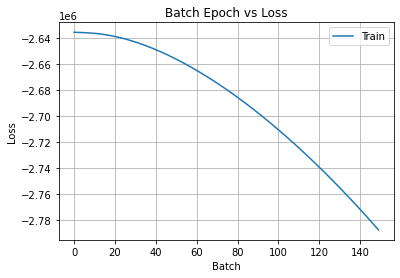

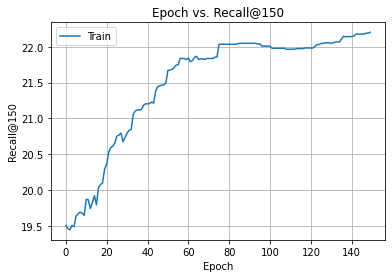

In [49]:
#loss function
def my_loss(model, a_matrix):
    
    ###compute optimization funtion 
    sig = nn.Sigmoid() #sigmoid funtion

    totalLoss =0 #store loss over matrix
    movie =model.movie_embedding(a_matrix) #movie embeddings

    #for each user in the matrix
    for u in range(a_matrix.shape[0]):

        ###get embeddigs
        #user u embedding
        current_user = model.user_embedding(torch.LongTensor([u]).to('cuda'))

        #embeddings for the movies that user u rated 5 starts and did not rate 5 stars
        pos_matrix = torch.squeeze(movie[u, torch.where(a_matrix[u,:]==1)[0], :]).T #rated 5 stars
        neg_matrix = torch.squeeze(movie[u,torch.where(a_matrix[u,:]==0)[0], :]).T #did not rate 5 stars

        ###compute function
        #positive sum
        posSum_dot =  torch.matmul(current_user,pos_matrix)#dot product
        posSum_sig = sig(posSum_dot) #sigmoid of dot product
        posSum_log = torch.log(posSum_sig) #log funtion of sum
        posSum = 200*torch.sum(posSum_log) #final positive value

        #negative sum
        negSum_dot =  torch.matmul(current_user,neg_matrix) #dot product 
        negSum_sig = sig(negSum_dot) #sigmoid of dot product
        negSum_log = torch.log(negSum_sig) #log funtion of sum
        negSum = torch.sum(negSum_log) #final positive value

        #final value
        totalLoss -= (posSum - negSum) #need the negative of the function
    
    #return loss
    return (totalLoss) 

###Define model, train model, test model
#Define Model Params
learning_rate = 0.00001 # learning rate
epochs = 150# number of epochs
d = 10 #number of embeddings
device = 'cuda' #run on GPU

#Define Model
model =Embedding(n_users,n_movies, d).to(device) 

#Define Optimizer
optimizer = torch.optim.Adam(model.parameters(), learning_rate) 

#List to store train results
train_loss_epoch = []
train_accuracy = []

#epoch to train
for epoch in range(epochs):

    totalLoss = 0 #store loss for each batch
    
    #batch each loop due to size constraints
    for batch in range(0,610,20):
        optimizer.zero_grad() #zero optimizer
        loss = my_loss(model.to(device) ,A_train_Tensor[batch:batch+20,:]) #get loss
        loss.backward() #update loss gradients
        totalLoss += loss.item() #add loss to master list for this epoch
        optimizer.step() #step optimizer
    train_loss_epoch.append(totalLoss) #store total loss for this epoch

    ###Accuracy for Epoch
    train_accuracy.append(recall150(A_train_Tensor, trainDf, model,mappedUsers,mappedMovies)) #store recall@150 for this epoch
 
    ###Print results of this round
    print('Epoch: %04d  Training Loss: %.2f  Training Accuracy: %.2f  ' % (epoch + 1, totalLoss, train_accuracy[-1]))


###Plots of  Accuracy and Loss
#Plot Loss for Each Epoch
plt.title("Batch Epoch vs Loss")
plt.plot(train_loss_epoch, label="Train")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.grid()
plt.show()

#Plot Recall@150 for each epoch
plt.title("Epoch vs. Recall@150")
plt.plot(train_accuracy, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Recall@150")
plt.legend(loc='best')
plt.grid()
plt.show()



<h3> Recall@150 </h3>

In [50]:
###Calculate the Recall@150 on the Train and Test Set 
#accuracy of entire train and test set
accuracy_train = recall150(A_train_Tensor, trainDf, model,mappedUsers,mappedMovies) 
accuracy_test = recall150(A_test_Tensor, testDf, model,mappedUsers,mappedMovies)

print('Training Accuracy: %.2f  Testing Accuracy: %.2f  ' % (accuracy_train, accuracy_test))


Training Accuracy: 22.20  Testing Accuracy: 16.62  


<h2> Part 2: Node2Vec </h2>

<h3> Prepare Test, Validate, and Train Data Set </h3>

In [23]:
###Split Data in Train/Validation/Test Set. Use 70/20/10 split.
#store train, validation and test df
trainDf_n2v = []
testDf_n2v = []
validationDf_n2v = []

#loop for all users
for i in range(n_users):
    tempUser = ratings[ratings['userId'] == i].copy().reset_index(drop = True) #df corresponding to this user
   
    n_temp_user = len(tempUser) #number of rows in df corresponding to this user
    n_train = int(0.7*n_temp_user) #make 70% of these rows for train set
    n_validate = int(0.2*(n_temp_user-n_train)) #make 20% of these rows for validation set
    
    #split df corresponding to this user into train,validate and test set
    trainDf_n2v.append(tempUser.iloc[0:n_train])
    validationDf_n2v.append(tempUser.iloc[n_train:n_validate+n_train])
    testDf_n2v.append(tempUser.iloc[n_train+n_validate:])

#concat df's
trainDf_n2v = pd.concat(trainDf_n2v).reset_index(drop = True)
validationDf_n2v = pd.concat(validationDf_n2v).reset_index(drop = True)
testDf_n2v = pd.concat(testDf_n2v).reset_index(drop = True)

<h3> Prepare Adjacency Matrix </h3>

In [24]:
###Make Adjacency Matrix
#train set
A_train_n2v = np.zeros((n_users,n_movies))

#validation set
A_validate_n2v = np.zeros((n_users,n_movies))

#test set
A_test_n2v = np.zeros((n_users,n_movies))

##Fill in the userxmovie matrix. Make graph to find which movies each user rated 5 stars.
for x in range(0,n_users):
    ##train set
    #query dataframe for subset belonging to user x
    usersRow_train_n2v = trainDf_n2v[trainDf_n2v['userId'] == x]
    #Get index corresponding to movie, get targets ( whether or not user gave it 5 stars)
    movieIdx_train_n2v = list(usersRow_train_n2v['movieId'])
    didGiveFive_train_n2v = list(usersRow_train_n2v['targets'])
    #update dataframe
    A_train_n2v[x][movieIdx_train_n2v] = didGiveFive_train_n2v

    ##validation set 
    #query dataframe for subset belonging to user x
    usersRow_validate_n2v = validationDf_n2v[validationDf_n2v['userId'] == x]
    #Get index corresponding to movie, get targets ( whether or not user gave it 5 stars)
    movieIdx_validate_n2v = list(usersRow_validate_n2v['movieId'])
    didGiveFive_validate_n2v = list(usersRow_validate_n2v['targets'])
    #update dataframe
    A_validate_n2v[x][movieIdx_validate_n2v] = didGiveFive_validate_n2v

    ##test set 
    #query dataframe for subset belonging to user x
    usersRow_test_n2v = testDf_n2v[testDf_n2v['userId'] == x]
    #Get index corresponding to movie, get targets ( whether or not user gave it 5 stars)
    movieIdx_test_n2v = list(usersRow_test_n2v['movieId'])
    didGiveFive_test_n2v = list(usersRow_test_n2v['targets'])
    #update dataframe
    A_test_n2v[x][movieIdx_test_n2v] = didGiveFive_test_n2v

###Convert to Tensor
A_train_Tensor_n2v = torch.LongTensor(A_train_n2v).to('cuda') 
A_validate_Tensor_n2v = torch.LongTensor(A_validate_n2v).to('cuda') 
A_test_Tensor_n2v = torch.LongTensor(A_test_n2v).to('cuda') 

<h3> Embedding Model </h3>

In [25]:
#Embeddings
class Embedding_node2vec(torch.nn.Module):
    def __init__(self, n_user, n_movies, d):        
        super(Embedding_node2vec, self).__init__()
        self.user_embedding = nn.Embedding(n_user,d) #user embeddings
        self.movie_embedding = nn.Embedding(n_movies,d) #movie embeddings
        self.user = n_user #number of users
        self.movies = n_movies #number of movies
        nn.init.uniform_(self.user_embedding.weight, -0.01, 0.01) #init user embedding weights
        nn.init.uniform_(self.movie_embedding.weight, -0.01, 0.01) #init movie embedding weights

<h3> Random Walks and Loss Function </h3

In [27]:
#random walk for next node
def next_user(a_matrix, last_user, current_user, p, q):

    ###constants
    edge = list(torch.where(a_matrix[:,current_user] == 1)[0]) #movies rated 5 stars
    neighbors = np.arange(a_matrix.shape[0]) #numpy version of all users in the graph for random choice 
    weights = np.array([1/q]*len(neighbors)) #store weights

    ###determine the weights for each case
    same_last = np.where(neighbors == last_user)[0] 
    in_edge = np.where(neighbors in edge)[0]

    ###update weights for each neighbor
    if len(same_last) != 0: 
      weights[same_last]= 1 
    
    if len(in_edge) != 0:
      weights[in_edge] = 1/p
        
    #weighted prob for each neighbors
    prob = [w/sum(weights) for w in weights]

    #prob for each neighbors
    return np.random.choice(neighbors, size=1, p=prob)[0]  #randomly select next node based on prob

#random walk
def random_walk(a_matrix, walks, steps, p, q):

    walk_list = [] #store walks
    users = np.arange(a_matrix.shape[0]) #list of all users
    
    #random walk
    for walk in range(walks):
        np.random.shuffle(users) #shuffle all users
       
        #loop for each user
        for user in users:
             walk_list.append(user) #store first walk
            
             #loop through the number of steps for each walk
             for i in range(steps):
           
                #get the last user vistied 
                try:
                  last_user = walk_list[-2]  
                except:
                   last_user = None
                
                #Compute the next user to visit, add it to the walk
                walk_list.append(next_user(a_matrix, last_user, walk_list[-1], p, q))

    return walk_list

#loss fcn
def my_loss_n2v(model, a_matrix, walks, steps, p, q):
 
  ###compute optimization funtion 
  sig = nn.Sigmoid() #sigmoid funtion
  totalLoss =0 #store loss over matrix

  #movie embedding
  movie = model.movie_embedding(a_matrix.to('cuda')).to('cuda')

  #for each user in the a_matrix
  for u in range(a_matrix.shape[0]):

    z_u = model.user_embedding(torch.LongTensor([u]).to('cuda')) #user embedding
    N_R_Index = random_walk(a_matrix, walks, steps, p, q) #random walks users
    N_R = movie[u,N_R_Index, :] #random walk users embeddings

    #compute values
    numerator = torch.exp(torch.matmul(z_u, N_R.T)) #numerator value in fcn
    sum = 0 #total sum
    
    #loop for each user a second time
    for n in range(a_matrix.shape[0]):
      z_n = model.user_embedding(torch.LongTensor([n]).to('cuda') ) #zn vector
      sum = torch.sum(torch.exp(torch.matmul(z_u.T, z_n))) #sum of all 

    #final total value
    totalLoss += -1*torch.sum(torch.log(torch.divide(numerator,sum)))

  return (-1*totalLoss) 



<h3>Train and Validate Model </h3>

<h4> Hyperparameter Tuning </h4

Tune the p/q values and num walks/num steps. Found that different learning rate values either lead to poor results or a loss value of nan.

<h5> Hyperparameter Tuning Variation 1 </h5>

Epoch: 0001  Training Loss: -668670.52  Training Accuracy: 18.72  Validation Loss: -668674.20  Validation Accuracy: 8.16  
Epoch: 0002  Training Loss: -668678.20  Training Accuracy: 18.90  Validation Loss: -668683.08  Validation Accuracy: 8.16  
Epoch: 0003  Training Loss: -668689.03  Training Accuracy: 19.27  Validation Loss: -668697.10  Validation Accuracy: 8.16  
Epoch: 0004  Training Loss: -668707.60  Training Accuracy: 20.01  Validation Loss: -668722.29  Validation Accuracy: 8.16  
Epoch: 0005  Training Loss: -668741.74  Training Accuracy: 20.09  Validation Loss: -668769.18  Validation Accuracy: 8.16  
Epoch: 0006  Training Loss: -668805.97  Training Accuracy: 20.25  Validation Loss: -668858.08  Validation Accuracy: 8.48  
Epoch: 0007  Training Loss: -668927.21  Training Accuracy: 20.78  Validation Loss: -669026.17  Validation Accuracy: 8.48  
Epoch: 0008  Training Loss: -669157.11  Training Accuracy: 21.30  Validation Loss: -669344.36  Validation Accuracy: 8.48  
Epoch: 0009  Tra

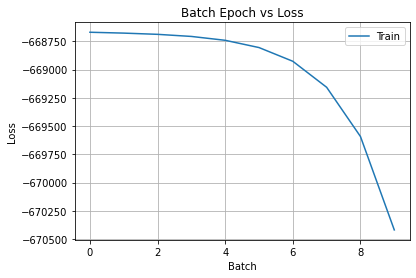

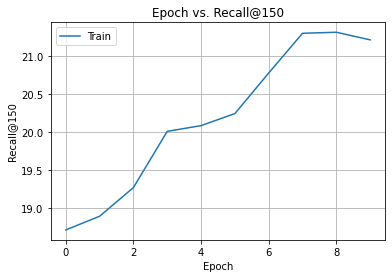

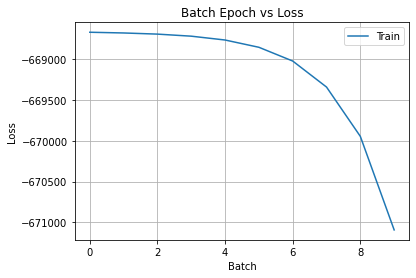

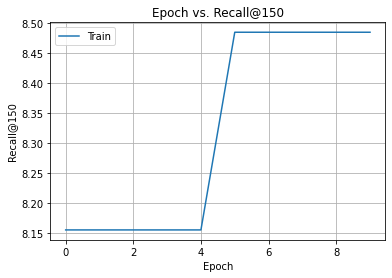

In [33]:

###Define model, train model, test model
#Define Model Params
learning_rate_n2v = 0.00001 # learning rate
epochs_n2v = 10# number of epochs
d_n2v = 10 #number of embeddings
device = 'cuda' #run on GPU
num_walks = 3
num_steps = 3
p = 3
q = 4

#Define Model
model_n2v =Embedding_node2vec(n_users,n_movies, d_n2v).to(device) 

#Define Optimizer
optimizer_n2v = torch.optim.SGD(model_n2v.parameters(), learning_rate_n2v)

#List to store train results
train_loss_epoch_n2v = []
train_batch_loss_epoch_n2v = []
train_accuracy_n2v = []

#Lists to store train results
valid_loss_epoch_n2v = []
valid_batch_loss_epoch_n2v= []
valid_accuracy_n2v = []


#epoch to train
for epoch in range(epochs_n2v):

  ###Train Set
  train_totalLoss_n2v = 0 #store loss for each batch

  #for each batch  
  for batch in range(0,610,20):
      optimizer_n2v.zero_grad() #zero optimizer
      loss_n2v = my_loss_n2v(model_n2v.to(device), A_train_Tensor_n2v[batch:batch+20,:], num_walks, num_steps, p, q)#get loss
      loss_n2v.backward() #update loss gradients
      train_totalLoss_n2v += loss_n2v.item() #add loss to master list for this epoch
      train_loss_epoch_n2v.append(loss_n2v.item()) #store batch loss
      optimizer_n2v.step() #step optimizer
  train_batch_loss_epoch_n2v.append(train_totalLoss_n2v) #store total loss for this epoch

  ###Accuracy (Recall@150) for Epoch
  train_accuracy_n2v.append(recall150(A_train_Tensor_n2v, trainDf_n2v, model_n2v,mappedUsers,mappedMovies)) #store recall@150 for this epoch
 
  ###Valid Set
  valid_totalLoss_n2v = 0 #store loss for each batch
  
  #for each batch  
  for batch in range(0,610,20):
      valid_loss_n2v = my_loss_n2v(model_n2v.to(device), A_validate_Tensor_n2v[batch:batch+20,:], num_walks, num_steps, p, q)#get loss
      valid_loss_n2v.backward() #update loss gradients
      valid_totalLoss_n2v += valid_loss_n2v.item() #add loss to master list for this epoch
      valid_loss_epoch_n2v.append(valid_loss_n2v.item()) #store batch loss
  valid_batch_loss_epoch_n2v.append(valid_totalLoss_n2v) #store total loss for this epoch

  ###Accuracy (Recall@150) for Epoch
  valid_accuracy_n2v.append(recall150(A_validate_Tensor_n2v,validationDf_n2v,model_n2v,mappedUsers,mappedMovies))

  #print results of this round
  print('Epoch: %04d  Training Loss: %.2f  Training Accuracy: %.2f  Validation Loss: %.2f  Validation Accuracy: %.2f  ' % (epoch + 1, train_totalLoss_n2v, train_accuracy_n2v[-1], valid_totalLoss_n2v,valid_accuracy_n2v[-1]))


###Plots of  Accuracy and Loss
#Plot Loss for Each Epoch
plt.title("Batch Epoch vs Loss")
plt.plot(train_batch_loss_epoch_n2v, label="Train")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.grid()
plt.show()

#Plot Accuracy for each epoch
plt.title("Epoch vs. Recall@150")
plt.plot(train_accuracy_n2v, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Recall@150")
plt.legend(loc='best')
plt.grid()
plt.show()

#Plot Loss for Each Epoch
plt.title("Batch Epoch vs Loss")
plt.plot(valid_batch_loss_epoch_n2v, label="Train")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.grid()
plt.show()

#Plot Accuracy for each epoch
plt.title("Epoch vs. Recall@150")
plt.plot(valid_accuracy_n2v, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Recall@150")
plt.legend(loc='best')
plt.grid()
plt.show()




<h5> Hyperparameter Tuning Variation 2 </h5>

Epoch: 0001  Training Loss: -445779.53  Training Accuracy: 19.13  Validation Loss: -445780.92  Validation Accuracy: 8.27  
Epoch: 0002  Training Loss: -445782.35  Training Accuracy: 19.06  Validation Loss: -445783.90  Validation Accuracy: 8.27  
Epoch: 0003  Training Loss: -445785.50  Training Accuracy: 19.14  Validation Loss: -445787.45  Validation Accuracy: 8.27  
Epoch: 0004  Training Loss: -445789.57  Training Accuracy: 19.21  Validation Loss: -445792.28  Validation Accuracy: 7.94  
Epoch: 0005  Training Loss: -445795.33  Training Accuracy: 19.50  Validation Loss: -445799.31  Validation Accuracy: 7.94  
Epoch: 0006  Training Loss: -445803.81  Training Accuracy: 19.95  Validation Loss: -445809.84  Validation Accuracy: 7.62  
Epoch: 0007  Training Loss: -445816.57  Training Accuracy: 20.33  Validation Loss: -445825.75  Validation Accuracy: 7.62  
Epoch: 0008  Training Loss: -445836.00  Training Accuracy: 20.65  Validation Loss: -445849.98  Validation Accuracy: 7.62  
Epoch: 0009  Tra

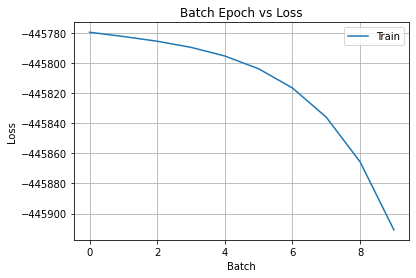

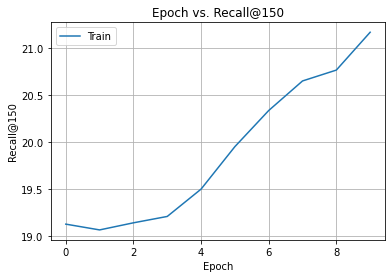

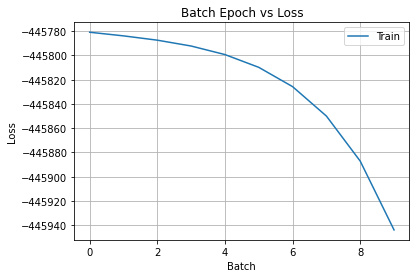

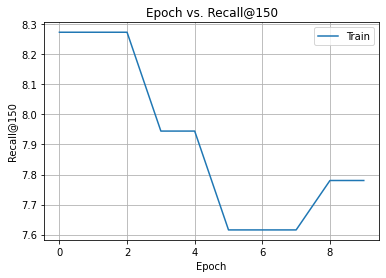

In [36]:
###Define model, train model, test model
#Define Model Params
learning_rate_n2v_2 = 0.00001 # learning rate
epochs_n2v_2 = 10# number of epochs
d_n2v = 10 #number of embeddings
device = 'cuda' #run on GPU
num_walks_2 = 3
num_steps_2 = 3
p_2 = 3
q_2 = 5

#Define Model
model_n2v_2 =Embedding_node2vec(n_users,n_movies, d_n2v).to(device) 

#Define Optimizer
optimizer_n2v_2 = torch.optim.SGD(model_n2v_2.parameters(), learning_rate_n2v_2)

#List to store train results
train_loss_epoch_n2v_2 = []
train_batch_loss_epoch_n2v_2 = []
train_accuracy_n2v_2 = []

#Lists to store train results
valid_loss_epoch_n2v_2 = []
valid_batch_loss_epoch_n2v_2= []
valid_accuracy_n2v_2 = []


#epoch to train
for epoch in range(epochs_n2v_2):

  ###Train Set
  train_totalLoss_n2v_2 = 0 #store loss for each batch
    
  for batch in range(0,610,20):
      optimizer_n2v_2.zero_grad() #zero optimizer
      loss_n2v_2 = my_loss_n2v(model_n2v_2.to(device), A_train_Tensor_n2v[batch:batch+20,:], num_walks, num_steps, p, q)#get loss
      loss_n2v_2.backward() #update loss gradients
      train_totalLoss_n2v_2 += loss_n2v_2.item() #add loss to master list for this epoch
      train_loss_epoch_n2v_2.append(loss_n2v_2.item()) #store batch loss
      optimizer_n2v_2.step() #step optimizer
  train_batch_loss_epoch_n2v_2.append(train_totalLoss_n2v_2) #store total loss for this epoch

  ###Accuracy (Recall@150) for Epoch
  train_accuracy_n2v_2.append(recall150(A_train_Tensor_n2v, trainDf_n2v, model_n2v_2,mappedUsers,mappedMovies)) #store recall@150 for this epoch

  ###Valid Set
  valid_totalLoss_n2v_2 = 0 #store loss for each batch
  
  for batch in range(0,610,20):
      valid_loss_n2v_2 = my_loss_n2v(model_n2v_2.to(device), A_validate_Tensor_n2v[batch:batch+20,:], num_walks, num_steps, p, q)#get loss
      valid_loss_n2v_2.backward() #update loss gradients
      valid_totalLoss_n2v_2 += valid_loss_n2v_2.item() #add loss to master list for this epoch
      valid_loss_epoch_n2v_2.append(valid_loss_n2v_2.item()) #store batch loss
  valid_batch_loss_epoch_n2v_2.append(valid_totalLoss_n2v_2) #store total loss for this epoch

  ###Accuracy (Recall@150) for Epoch
  valid_accuracy_n2v_2.append(recall150(A_validate_Tensor_n2v,validationDf_n2v,model_n2v_2,mappedUsers,mappedMovies))
  
  #print results of this round
  
  #print results of this round
  print('Epoch: %04d  Training Loss: %.2f  Training Accuracy: %.2f  Validation Loss: %.2f  Validation Accuracy: %.2f  ' % (epoch + 1, train_totalLoss_n2v_2, train_accuracy_n2v_2[-1], valid_totalLoss_n2v_2,valid_accuracy_n2v_2[-1]))


###Plots of  Accuracy and Loss
#Plot Loss for Each Epoch
plt.title("Batch Epoch vs Loss")
plt.plot(train_batch_loss_epoch_n2v_2, label="Train")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.grid()
plt.show()

#Plot Accuracy for each epoch
plt.title("Epoch vs. Recall@150")
plt.plot(train_accuracy_n2v_2, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Recall@150")
plt.legend(loc='best')
plt.grid()
plt.show()

#Plot Loss for Each Epoch
plt.title("Batch Epoch vs Loss")
plt.plot(valid_batch_loss_epoch_n2v_2, label="Train")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.grid()
plt.show()

#Plot Accuracy for each epoch
plt.title("Epoch vs. Recall@150")
plt.plot(valid_accuracy_n2v_2, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Recall@150")
plt.legend(loc='best')
plt.grid()
plt.show()




<h5> Hyperparameter Tuning Variation 3 </h5>

Epoch: 0001  Training Loss: -835842.79  Training Accuracy: 20.49  Validation Loss: -835848.54  Validation Accuracy: 9.44  
Epoch: 0002  Training Loss: -835855.39  Training Accuracy: 20.58  Validation Loss: -835865.38  Validation Accuracy: 9.44  
Epoch: 0003  Training Loss: -835879.42  Training Accuracy: 20.87  Validation Loss: -835900.36  Validation Accuracy: 9.44  
Epoch: 0004  Training Loss: -835930.71  Training Accuracy: 21.53  Validation Loss: -835976.40  Validation Accuracy: 9.81  
Epoch: 0005  Training Loss: -836043.64  Training Accuracy: 21.86  Validation Loss: -836144.73  Validation Accuracy: 9.86  
Epoch: 0006  Training Loss: -836293.75  Training Accuracy: 22.45  Validation Loss: -836517.14  Validation Accuracy: 9.86  
Epoch: 0007  Training Loss: -836848.46  Training Accuracy: 22.73  Validation Loss: -837342.98  Validation Accuracy: 9.86  
Epoch: 0008  Training Loss: -838077.08  Training Accuracy: 22.80  Validation Loss: -839173.10  Validation Accuracy: 10.52  
Epoch: 0009  Tr

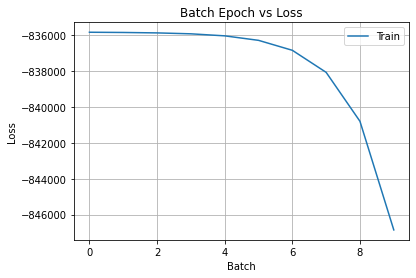

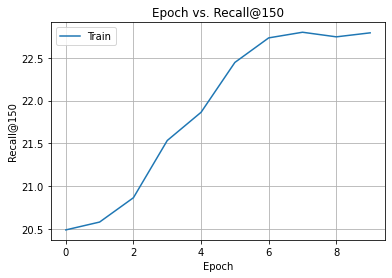

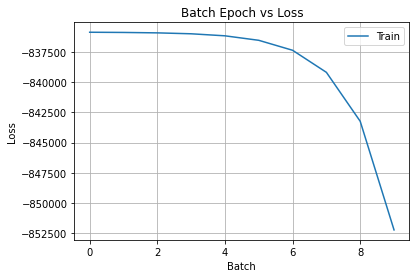

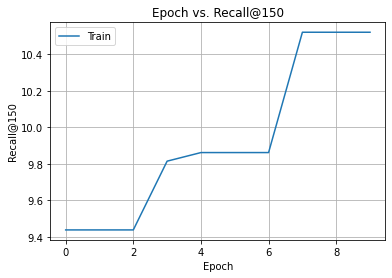

In [42]:
###Define model, train model, test model
#Define Model Params
learning_rate_n2v_3 = 0.00001 # learning rate
epochs_n2v_3 = 10# number of epochs
d_n2v_3 = 10 #number of embeddings
device = 'cuda' #run on GPU
num_walks = 3
num_steps = 4
p = 3
q = 4

#Define Model
model_n2v_3 =Embedding_node2vec(n_users,n_movies, d_n2v_3).to(device) 

#Define Optimizer
optimizer_n2v_3 = torch.optim.SGD(model_n2v_3.parameters(), learning_rate_n2v_3)

#List to store train results
train_loss_epoch_n2v_3 = []
train_batch_loss_epoch_n2v_3 = []
train_accuracy_n2v_3 = []

#Lists to store train results
valid_loss_epoch_n2v_3 = []
valid_batch_loss_epoch_n2v_3= []
valid_accuracy_n2v_3 = []


#epoch to train
for epoch in range(epochs_n2v_3):

  ###Train Set
  train_totalLoss_n2v_3 = 0 #store loss for each batch
    
  for batch in range(0,610,20):
      optimizer_n2v_3.zero_grad() #zero optimizer
      loss_n2v_3 = my_loss_n2v(model_n2v_3.to(device), A_train_Tensor_n2v[batch:batch+20,:], num_walks, num_steps, p, q)#get loss
      loss_n2v_3.backward() #update loss gradients
      train_totalLoss_n2v_3 += loss_n2v_3.item() #add loss to master list for this epoch
      train_loss_epoch_n2v_3.append(loss_n2v_3.item()) #store batch loss
      optimizer_n2v_3.step() #step optimizer
  train_batch_loss_epoch_n2v_3.append(train_totalLoss_n2v_3) #store total loss for this epoch

  ###Accuracy (Recall@150) for Epoch
  train_accuracy_n2v_3.append(recall150(A_train_Tensor_n2v, trainDf_n2v, model_n2v_3,mappedUsers,mappedMovies)) #store recall@150 for this epoch

  ###Valid Set
  valid_totalLoss_n2v_3 = 0 #store loss for each batch
  
  for batch in range(0,610,20):
      valid_loss_n2v_3 = my_loss_n2v(model_n2v_3.to(device), A_validate_Tensor_n2v[batch:batch+20,:], num_walks, num_steps, p, q)#get loss
      valid_loss_n2v_3.backward() #update loss gradients
      valid_totalLoss_n2v_3 += valid_loss_n2v_3.item() #add loss to master list for this epoch
      valid_loss_epoch_n2v_3.append(valid_loss_n2v_3.item()) #store batch loss
  valid_batch_loss_epoch_n2v_3.append(valid_totalLoss_n2v_3) #store total loss for this epoch

  ###Accuracy (Recall@150) for Epoch
  valid_accuracy_n2v_3.append(recall150(A_validate_Tensor_n2v,validationDf_n2v,model_n2v_3,mappedUsers,mappedMovies))
  
  #print results of this round
  
  #print results of this round
  print('Epoch: %04d  Training Loss: %.2f  Training Accuracy: %.2f  Validation Loss: %.2f  Validation Accuracy: %.2f  ' % (epoch + 1, train_totalLoss_n2v_3, train_accuracy_n2v_3[-1], valid_totalLoss_n2v_3,valid_accuracy_n2v_3[-1]))


###Plots of  Accuracy and Loss
#Plot Loss for Each Epoch
plt.title("Batch Epoch vs Loss")
plt.plot(train_batch_loss_epoch_n2v_3, label="Train")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.grid()
plt.show()

#Plot Accuracy for each epoch
plt.title("Epoch vs. Recall@150")
plt.plot(train_accuracy_n2v_3, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Recall@150")
plt.legend(loc='best')
plt.grid()
plt.show()

#Plot Loss for Each Epoch
plt.title("Batch Epoch vs Loss")
plt.plot(valid_batch_loss_epoch_n2v_3, label="Train")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.grid()
plt.show()

#Plot Accuracy for each epoch
plt.title("Epoch vs. Recall@150")
plt.plot(valid_accuracy_n2v_3, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Recall@150")
plt.legend(loc='best')
plt.grid()
plt.show()




<h3> Recall@150 </h3>

In [44]:
###Calculate the Recall@150 on the Train, Validate and Test Set for the best set of hyperparameters
### Best validation accuracy was on model 3, therefore comput test set recall@150 om test set using model 3
accuracy_train_n2v = recall150(A_train_Tensor_n2v, trainDf_n2v, model_n2v_3,mappedUsers,mappedMovies)
accuracy_validate_n2v = recall150(A_validate_Tensor_n2v,validationDf_n2v,model_n2v_3,mappedUsers,mappedMovies)
accuracy_test_n2v = recall150(A_test_Tensor_n2v,testDf_n2v, model_n2v_3,mappedUsers,mappedMovies)

print('Training Accuracy: %.2f Validation Accuracy: %.2f  Testing Accuracy: %.2f  ' % (accuracy_train_n2v,accuracy_validate_n2v, accuracy_test_n2v))

Training Accuracy: 22.79 Validation Accuracy: 10.52  Testing Accuracy: 14.64  
